# Natural Language Exploration

In [4]:
!pip install kagglehub[pandas-datasets] --quiet

In [5]:
!pip install transformers evaluate accelerate --quiet

In [ ]:
!pip install tensorflow[and-cuda] --quiet

In [7]:
# Data Related
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# NLP and DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Bidirectional,
                                     Dense,
                                     GlobalMaxPooling1D,
                                     Dropout)
# Misc
import sys

In [8]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
# Enable Tensor Core acceleration
mixed_precision.set_global_policy("mixed_float16")

Num GPUs Available: 1


## Version Check

In [9]:
print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('NumPy: {}'.format(np.__version__))
print('Tensorflow: {}'.format(tf.__version__))

Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Pandas: 2.2.2
NumPy: 1.26.4
Tensorflow: 2.18.0


In [31]:
file_path = "dataset-tickets-multi-lang-4-20k.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "tobiasbueck/multilingual-customer-support-tickets",
  file_path,
)

<ipython-input-31-3398c303bdef>:4: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


## Data Cleaning

### Filtering by English and Dropping Miscellaneous Columns

In [32]:
# Filtering by English
df = df[df['language'] == 'en']

# Defining Misc Tag Columns
misc_metadata = ['tag_2','tag_3','tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']

# Dropping those tags columns
df = df.drop(misc_metadata, axis=1)

df.head()

,subject,body,answer,type,queue,priority,language,tag_1
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security
5,Concerns About Securing Medical Data on 2-in-1...,Inquiring about best practices for securing me...,Thank you for your concern regarding securing ...,Request,Technical Support,medium,en,Security
7,Problem with Integration,"The integration stopped working unexpectedly, ...",I will look into the problem and call you at <...,Problem,IT Support,high,en,Technical


In [33]:
# Checking null entries
df.isnull().sum()

,0
subject,1032
body,1
answer,3
type,0
queue,0
priority,0
language,0
tag_1,0


### Imputing Null Subject Lines and Combining Request Data

In [35]:
# Imputing Null Subject Lines
df['subject'].fillna('[No Subject]', inplace=True)

print("Null Subject Values:", df['subject'].isnull().sum())

Null Subject Values: 0


In [38]:
# Combining subject and body data into one column
df["combined_request"] = df.apply(
    lambda row: f"Subject: {row['subject']} Body: {row['body']}", axis=1
).fillna('')

df["combined_request"].head()

,combined_request
1,Subject: Customer Support Inquiry Body: Seekin...
2,Subject: Data Analytics for Investment Body: I...
4,"Subject: Security Body: Dear Customer Support,..."
5,Subject: Concerns About Securing Medical Data ...
7,Subject: Problem with Integration Body: The in...


## Feature Engineering

In [40]:
df

,subject,body,answer,type,queue,priority,language,tag_1,combined_request
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Subject: Customer Support Inquiry Body: Seekin...
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Subject: Data Analytics for Investment Body: I...
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,"Subject: Security Body: Dear Customer Support,..."
5,Concerns About Securing Medical Data on 2-in-1...,Inquiring about best practices for securing me...,Thank you for your concern regarding securing ...,Request,Technical Support,medium,en,Security,Subject: Concerns About Securing Medical Data ...
7,Problem with Integration,"The integration stopped working unexpectedly, ...",I will look into the problem and call you at <...,Problem,IT Support,high,en,Technical,Subject: Problem with Integration Body: The in...
...,...,...,...,...,...,...,...,...,...
19992,Guidelines for Securing Medical Data in OBS St...,Seeking details on securing medical data using...,Offering general security guidelines for OBS S...,Request,Technical Support,high,en,Security,Subject: Guidelines for Securing Medical Data ...
19993,[No Subject],Can you provide information on digital strateg...,I would be happy to discuss digital strategies...,Request,Billing and Payments,medium,en,Feedback,Subject: [No Subject] Body: Can you provide in...
19994,Support for Marketing Enhancements,Request for assistance in improving digital ma...,Ready to help with your marketing support need...,Change,Technical Support,high,en,Feedback,Subject: Support for Marketing Enhancements Bo...
19995,Assistance Needed for IFTTT Docker Integration,I am facing integration problems with IFTTT Do...,I would be happy to assist with the IFTTT Dock...,Problem,Technical Support,low,en,Integration,Subject: Assistance Needed for IFTTT Docker In...


In [45]:
# Limiting data for our text classifier - priority = target
model_data = df[["combined_request","type", "tag_1","priority"]]

model_data.head()

,combined_request,type,tag_1,priority
1,Subject: Customer Support Inquiry Body: Seekin...,Request,Feedback,medium
2,Subject: Data Analytics for Investment Body: I...,Request,Technical,medium
4,"Subject: Security Body: Dear Customer Support,...",Request,Security,medium
5,Subject: Concerns About Securing Medical Data ...,Request,Security,medium
7,Subject: Problem with Integration Body: The in...,Problem,Technical,high


### **Optional**: Approach to using tags as an input feature

In [50]:
# Find the top 3 most frequent tags
top_tags = model_data['tag_1'].value_counts().nlargest(3).index

# Replace less frequent values with "Other"
model_data['tag_1'] = model_data['tag_1'].apply(lambda x: x if x in top_tags else 'Other')

print(model_data['tag_1'].value_counts())

tag_1
Other        5580
Technical    3057
Security     2033
Bug          1253
Name: count, dtype: int64


<ipython-input-50-f77e8b653f85>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['tag_1'] = model_data['tag_1'].apply(lambda x: x if x in top_tags else 'Other')


### Label Encoding

In [54]:
# Instantiating the label encoder
le = LabelEncoder()

# Fit the LabelEncoder on the 'priority' column and transform the labels
labels = le.fit_transform(model_data['priority'])
print("Target Classes:", le.classes_)

feature_inputs = le.fit_transform(model_data['type'])
# Fit the LabelEncoder on the 'type' column
print("Feature Classes:", le.classes_)

Target Classes: ['high' 'low' 'medium']
Feature Classes: ['Change' 'Incident' 'Problem' 'Request']


### Text Preprocessing

In [64]:
# TODO: Get count of all unique words
# Vocabulary Size (we'll change later)
max_words = 10000

# Max token length per text (We'll change later)
max_length = 512 # TODO: Run distribution of word count for "body" column

# Instantiating and fitting tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(model_data['combined_request'])

# Convert text into sequences of integers
sequences = tokenizer.texts_to_sequences(model_data['combined_request'])

# Padding sequences to ensure uniform input length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post',
                                 truncating='post')

# Reshaping and combining input features
feature_inputs = feature_inputs.reshape(-1,1)
features_combined = np.concatenate([padded_sequences,feature_inputs], axis=1)

# Convert labels to a NumPy array
labels = np.array(labels)

### Splitting Data

In [104]:
x_train,x_test,y_train,y_test = train_test_split(
    features_combined,labels,test_size=0.2,random_state=42,shuffle=True,
    stratify=labels)

## Modeling (LSTM)

In [105]:
# Model Parameters
embedding_dim = 128
lstm_units = 128  # Increase LSTM units for longer text sequences
num_classes = 3

# Define the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(lstm_units // 2, return_sequences=True)),
    GlobalMaxPooling1D(),  # Pooling over the entire sequence
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Multi-class output with 'softmax'
])

# Compile the model for multi-class classification
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
                )

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [106]:
'''
Monitors the training loss of the model and terminates the training process
if the loss doesn't improve for 5 consecutive epochs.
'''
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=5,
                                                           restore_best_weights=True)

"""
Saves the best model (best_model.h5) in workign directory.
Ensures the model is only saved if the monitored metric (`val_loss`) improves.
Since we want to minimize the validation loss, we set this to `min`.
"""
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Small Training session, we'll adjust epochs later
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping_callback, checkpoint_callback]
)


Epoch 1/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3966 - loss: 1.0627
Epoch 1: val_loss improved from inf to 1.02431, saving model to best_model.h5


299/299 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.3967 - loss: 1.0627 - val_accuracy: 0.4709 - val_loss: 1.0243
Epoch 2/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4843 - loss: 1.0144
Epoch 2: val_loss improved from 1.02431 to 1.00178, saving model to best_model.h5


299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.4843 - loss: 1.0144 - val_accuracy: 0.4876 - val_loss: 1.0018
Epoch 3/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5497 - loss: 0.9420
Epoch 3: val_loss improved from 1.00178 to 0.99657, saving model to best_model.h5


299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.5497 - loss: 0.9420 - val_accuracy: 0.5048 - val_loss: 0.9966
Epoch 4/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5826 - loss: 0.8761
Epoch 4: val_loss did not improve from 0.99657
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.5826 - loss: 0.8761 - val_accuracy: 0.5044 - val_loss: 1.0167
Epoch 5/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6497 - loss: 0.7622
Epoch 5: val_loss did not improve from 0.99657
299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.6497 - loss: 0.7622 - val_accuracy: 0.5124 - val_loss: 1.0669
Epoch 6/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7153 - loss: 0.6635
Epoch 6: val_loss did not improve from 0.99657
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.7153 - loss: 0.6635 - val_accuracy: 0.5191 - val_loss: 1.2087
Epoch 7/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7538 - loss: 0.5813
Epoch 7: val_loss did not improve f

### Model Visualization

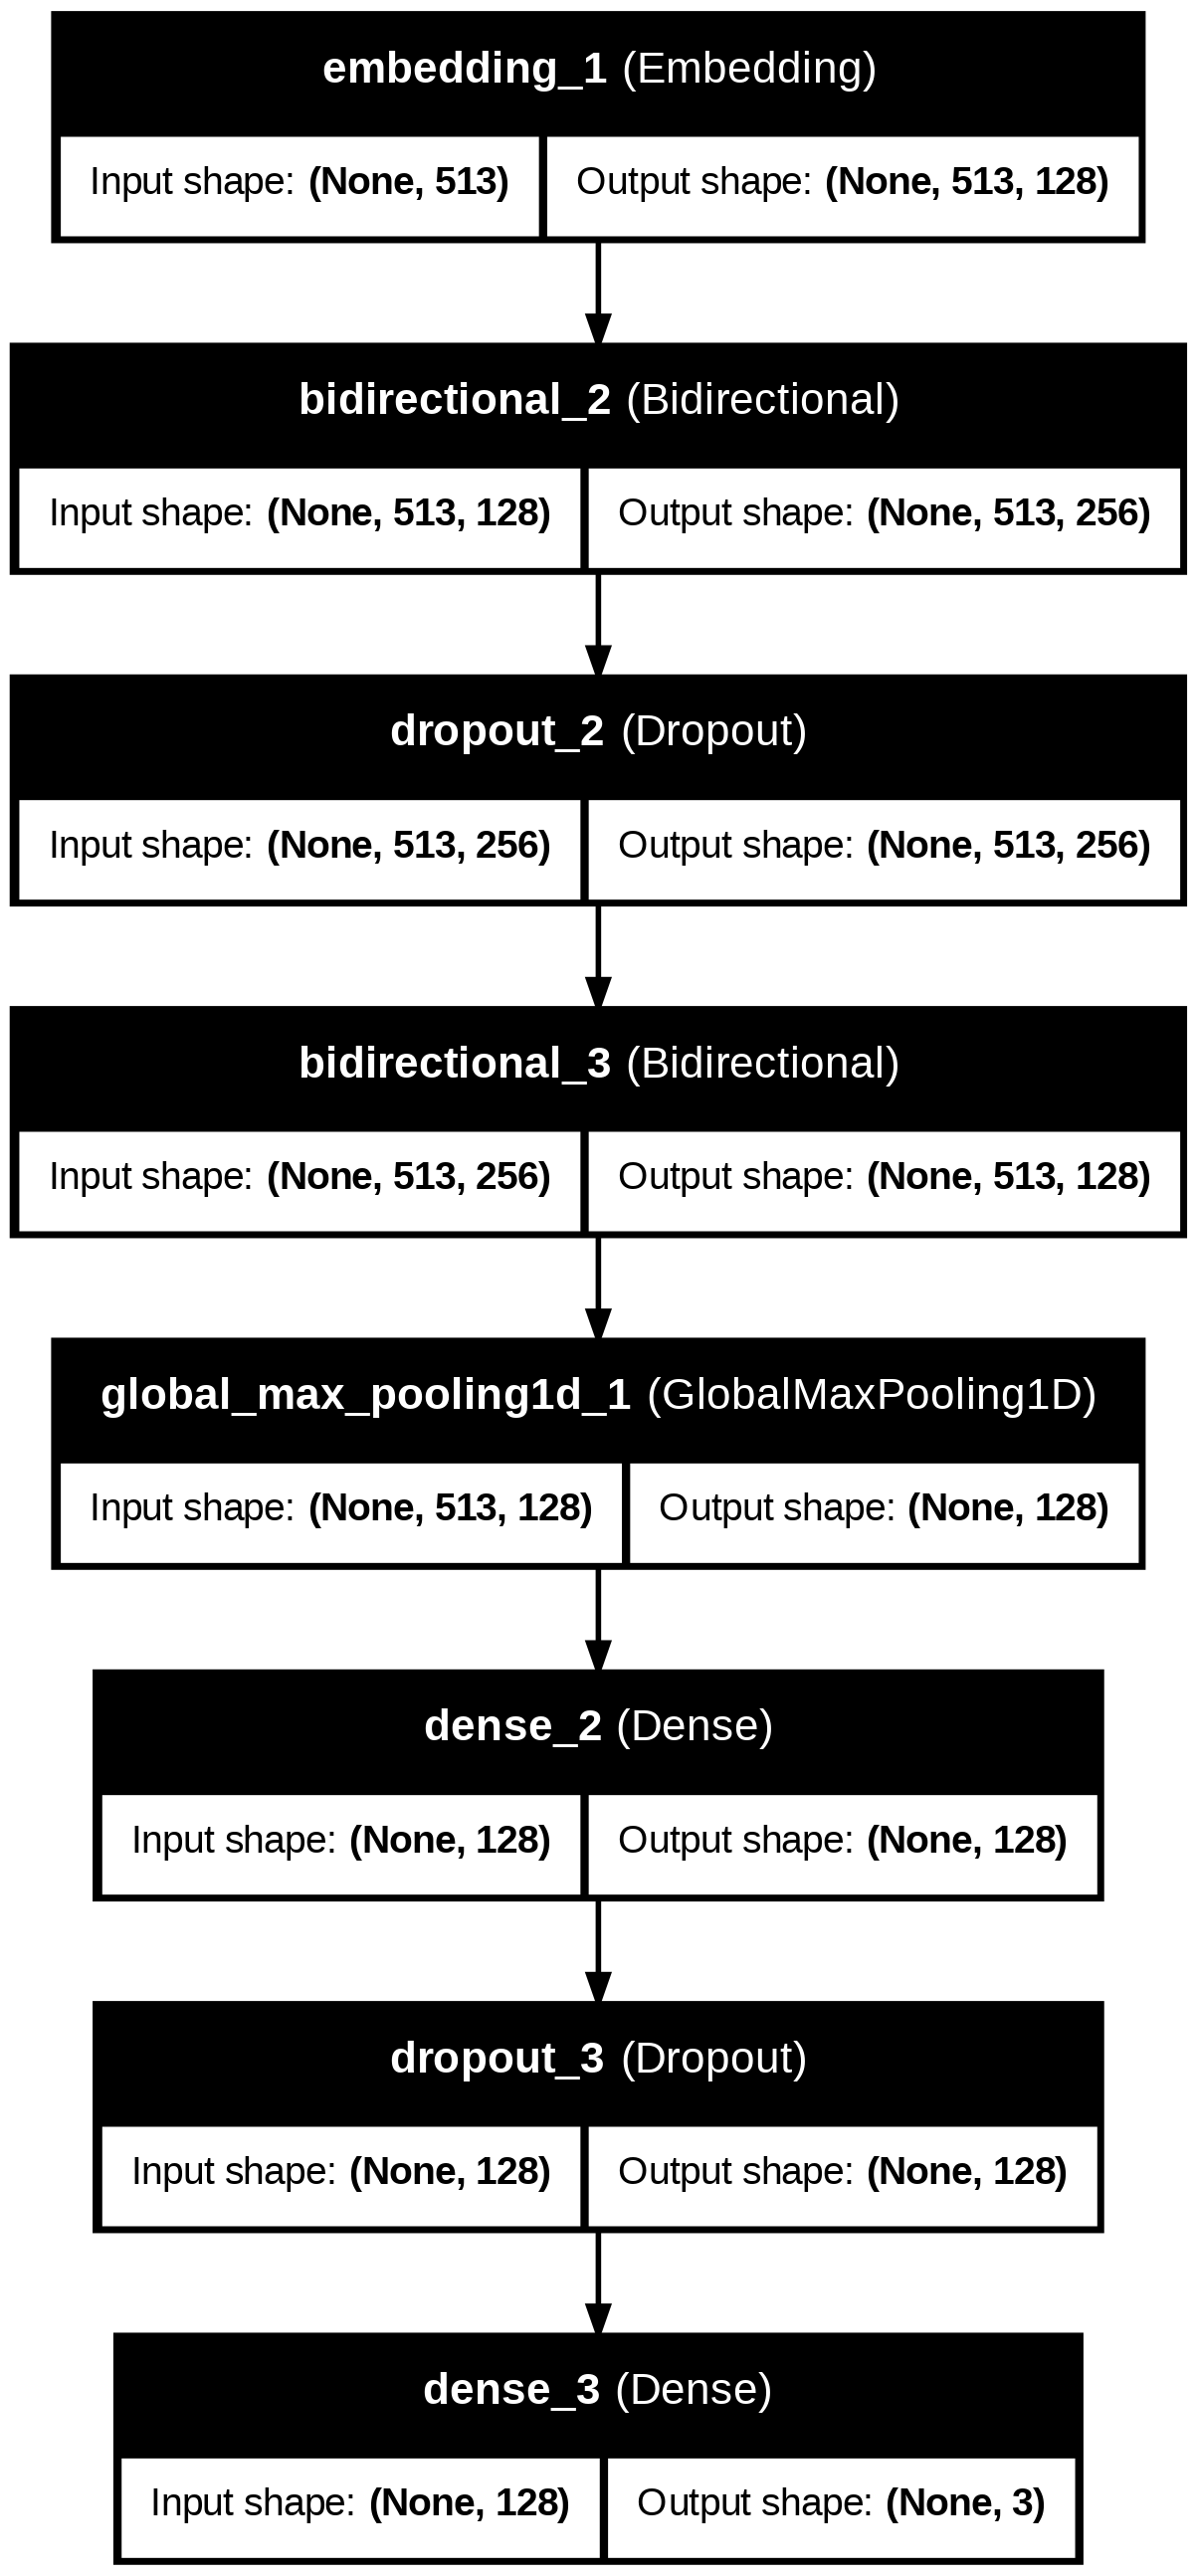

In [96]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

### Model Evaluation

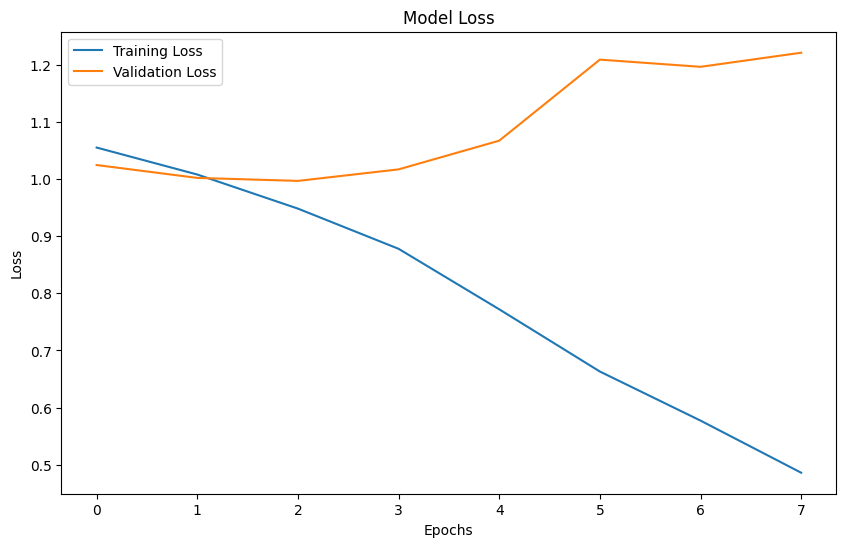

In [107]:
# Loss Plots
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

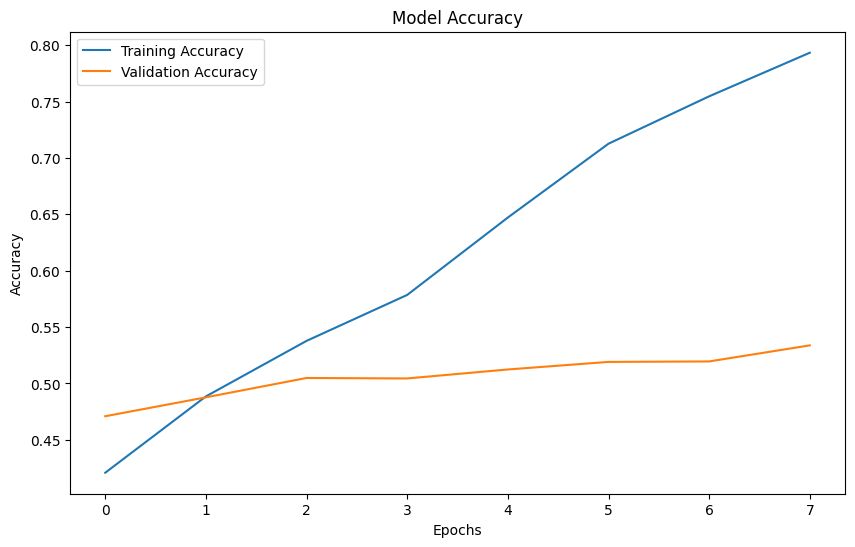

In [108]:
# Accuracy Plots
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The metrics below represent the priority probabilities of the incoming requests

In [110]:
predictions = model.predict(x_test)

predicted_classes = np.argmax(predictions, axis=1)

# Map predicted classes to priority
class_to_priority = {0: 'high', 1: 'low', 2: 'medium'}
predicted_priority = [class_to_priority[pred] for pred in predicted_classes]

# Displays all class probabilities for each sample
for i, pred in enumerate(predictions):
    print(f"Sample {i + 1}:")
    for class_idx, class_prob in enumerate(pred):
        print(f"  {class_to_priority[class_idx]}: {class_prob:.4f}")

Streaming output truncated to the last 5000 lines.
Sample 1136:
  high: 0.5018
  low: 0.1956
  medium: 0.3026
Sample 1137:
  high: 0.3079
  low: 0.2302
  medium: 0.4619
Sample 1138:
  high: 0.2502
  low: 0.2551
  medium: 0.4946
Sample 1139:
  high: 0.6679
  low: 0.0696
  medium: 0.2624
Sample 1140:
  high: 0.1546
  low: 0.3949
  medium: 0.4505
Sample 1141:
  high: 0.5656
  low: 0.0650
  medium: 0.3693
Sample 1142:
  high: 0.3717
  low: 0.1540
  medium: 0.4743
Sample 1143:
  high: 0.7376
  low: 0.0617
  medium: 0.2007
Sample 1144:
  high: 0.2514
  low: 0.2849
  medium: 0.4637
Sample 1145:
  high: 0.1848
  low: 0.4286
  medium: 0.3866
Sample 1146:
  high: 0.8544
  low: 0.0263
  medium: 0.1193
Sample 1147:
  high: 0.1741
  low: 0.3768
  medium: 0.4492
Sample 1148:
  high: 0.9380
  low: 0.0064
  medium: 0.0556
Sample 1149:
  high: 0.1921
  low: 0.3351
  medium: 0.4728
Sample 1150:
  high: 0.2014
  low: 0.3816
  medium: 0.4171
Sample 1151:
  high: 0.3446
  low: 0.1929
  medium: 0.4625
Sampl